In [0]:
# INSTRUCTIONS TO RUN -
# Instructions are given so that RAM is optimised till the end, 
# and every cell is correctly performed, for the final output to be correct
# Important instructions for the person who will be testing this work, are given in each cell.
# PLEASE RUN THE CELLS IN THE ORDER THEY ARE ARRANGED, ELSE RAM WILL NOT BE SUFFICIENT AND IT MAY CRASH

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()
# Making sure GPU is used. If output is '/device:GPU:0' the fine. Else please go to Runtime -> Change Runtime Type ->Hardware as GPU

'/device:GPU:0'

In [2]:
!pip install -U -q kaggle
!pip install --upgrade kaggle
!mkdir -p ~/.kaggle


Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [4]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1.1)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
# Create a kaggle.json file on your desktop. Click on the profile icon on Kaggle Website, my account, Create API Token, download the file and upload here.

In [5]:
from google.colab import files
files.upload()
# Upload the kaggle.json, while the icon is circling. If it stops, run again, and then upload before it stops.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saky098","key":"91040df92dbed061b1661a1bd37bee51"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
# Kaggle setup

In [0]:
! chmod 600 ~/.kaggle/kaggle.json
# Permission setup

In [8]:
!kaggle datasets list
# kaggle setup successful, if ref-title-size----- table appears below.

ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-05-20 17:23:43          71059       6779  0.88235295       
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          10253        713  0.8235294        
susuwatari/epa-vehicle-dataset-19802021                     EPA Vehicle Dataset (~1980-2021)                      2MB  2020-05-10 18:20:19            423         21  0.7941176        
idoyo92/epl-stats-20192020                                  English Premier Leag

In [9]:
!kaggle competitions download -c ultrasound-nerve-segmentation
!ls
# DATASET DOWNLOAD FROM KAGGLE

100% 2.11G/2.11G [00:30<00:00, 81.9MB/s]
100% 2.11G/2.11G [00:30<00:00, 74.8MB/s]
kaggle.json  sample_data  ultrasound-nerve-segmentation.zip


In [10]:
!pwd
# Make sure you are in /content folder

/content


In [11]:
from zipfile import ZipFile
data_file = "ultrasound-nerve-segmentation.zip"

with ZipFile(data_file, 'r') as zip:
  zip.extractall()
  print('Done')
# Unzipping the dataset. 2 folders of train & test appear in the left folder structure. Train has 11270 images 
# and test has 5580. So do not open the folders. If you open, give some time for the folder to load, else Chrome
# stops responding. 

Done


In [0]:
import pandas as pd
import imageio

In [13]:
# IMPORTING LIBRARIES
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
# from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, \
    add, multiply
from keras.layers import concatenate, core, Dropout
# from keras.models import Model
# from keras.layers.merge import concatenate
# from keras.optimizers import Adam
# from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K


import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Make sure 'Using TensorfloW backend' appears

Using TensorFlow backend.


In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

In [15]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [0]:
# ATTENTION GATES
def attention_block(input_x, input_g, inter_channel):
    output_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format='channels_last')(input_x)
    output_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format='channels_last')(input_g)
    f_act = Activation('relu')(add([output_x, output_g]))

    psi_relu = Conv2D(1, [1, 1], strides=[1, 1], data_format='channels_last')(f_act)
    resampler_output_alpha = Activation('sigmoid')(psi_relu)
    attention = multiply([input_x, resampler_output_alpha])
    return attention



In [0]:

def attentionConcatenate(first_layer, second_layer):
    in_channel = first_layer.get_shape().as_list()[3]
    up_output = UpSampling2D(size=(2, 2), data_format='channels_last')(first_layer)
    second_layer = attention_block(input_x=second_layer, input_g = up_output, inter_channel=in_channel // 4)

    newconcate = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
    ans = newconcate([up_output, second_layer])
    return ans




In [0]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 

    axes = tuple(range(1, len(y_pred.shape)-1)) 
    n = 2. * K.sum(y_pred * y_true, axes)
    d = K.sum(K.square(y_pred) + K.square(y_true), axes)

    return 1 - K.mean(n / (d + epsilon)) 

In [0]:
def dice_coef(y_true, y_pred):
    s = 1
    inter = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * inter + s) / (union + s), axis=0)

In [0]:

def att_unet():
    width = 96 
    height = 96
    outputChannel = 1
    data_format='channels_last'
    imageData = Input((width, height, 1))
    x = imageData
    num = 3
    factor = 64
    arr = []

    for i in range(num):
        x = Conv2D(factor, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(factor, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
        arr.append(x)
        x = MaxPooling2D((2, 2), strides = (2,2), padding = 'same')(x)
        factor = factor * 2

    x = Conv2D(factor, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(factor, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)

    for i in reversed(range(num)):
        factor = factor // 2
        x = attentionConcatenate(x, arr[i])
        x = Conv2D(factor, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(factor, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)

    conv6 = Conv2D(outputChannel, (1, 1), padding='same', data_format='channels_last')(x)
    conv7 = core.Activation('sigmoid')(conv6)
    model = Model(inputs=imageData, outputs=conv7)

    # model.compile(optimizer=Adam(lr=1e-5), loss=[focal_loss()], metrics=['accuracy', dice_coef])
    # loss=dice_coef_loss, metrics=[dice_coef]
    # model.compile(optimizer=Adam(lr=1e-5), loss=[dice_coef_loss], metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=[soft_dice_loss], metrics=['accuracy', dice_coef])
    return model



In [21]:
model = att_unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 96, 96, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 64)   36928       dropout_1[0][0]                  
____________________________________________________________________________________________

In [0]:
root_path = './'
rowsize = 420
colsize = 580


In [0]:
def loadTrainingDataset():
    print('doing')
    folder_path = os.path.join(root_path, 'train')
    all_images = os.listdir(folder_path)
    total = len(all_images)/2

    Xtrain = np.ndarray((int(total), rowsize, colsize), dtype=np.float32)
    Ytrain = np.ndarray((int(total), rowsize, colsize), dtype=np.float32)
    
    i = 0
      # loop runs 11270 times, 
    print('Working')
    for imgname in all_images:
        if 'mask' in imgname:
            continue
        ytrain_name = imgname.split('.')[0] + '_mask.tif'
        x = imread(os.path.join(folder_path, imgname), as_gray=True)
        y = imread(os.path.join(folder_path, ytrain_name), as_gray=True)

        x = np.array([x])
        y = np.array([y])

        Xtrain[i] = x
        Ytrain[i] = y

        if i % 100 == 0:
            print('Loaded: {0}/{1} images'.format(i, total))
        i += 1 

    print('Loading done.')
    print('Creating X_train.npy')
    np.save('X_train.npy', Xtrain)
    print('Done')
    print('Creating Y_train.npy')
    np.save('Y_train.npy', Ytrain)
    print('Saving done.')





In [0]:
def loadTestingDataset():
    print('doing')
    folder_path = os.path.join(root_path, 'test')
    all_images = os.listdir(folder_path)
    total = len(all_images)

    Xtest = np.ndarray((int(total), rowsize, colsize), dtype=np.float32)
    test_ids = np.ndarray((int(total), ), dtype=np.int32)
    
    i = 0
      # loop runs 5580 times, 
    print('Working')
    for imgname in all_images:
        img_id = int(imgname.split('.')[0])
        img = imread(os.path.join(folder_path, imgname), as_gray=True)

        img = np.array([img])

        Xtest[i] = img
        test_ids[i] = img_id

        if i % 100 == 0:
            print('Loaded: {0}/{1} images'.format(i, total))
        i += 1         

    print('Loading done.')
    print('Creating X_test.npy')
    np.save('X_test.npy', Xtest)
    print('Done')
    print('Creating test_ids.npy')
    np.save('test_ids.npy', test_ids)
    print('Saving done.')


In [0]:
def load_train_data_from_files():
  print('Xtrain getting loaded')
  a = np.load('X_train.npy')
  print('Ytrain getting loaded')
  b = np.load('Y_train.npy')
  print('Done')

  return a, b

In [0]:
def load_test_data_from_files():
    print('X_test getting loaded')
    a = np.load('X_test.npy')
    print('test_ids getting loaded')
    b = np.load('test_ids.npy')
    print('Done')
    return a, b

In [30]:
loadTrainingDataset()
# Even if RAM goes red, it wont crash.Do not stop the execution. It will go to grey, once loading done.

doing
Working
Loaded: 0/5635.0 images
Loaded: 100/5635.0 images
Loaded: 200/5635.0 images
Loaded: 300/5635.0 images
Loaded: 400/5635.0 images
Loaded: 500/5635.0 images
Loaded: 600/5635.0 images
Loaded: 700/5635.0 images
Loaded: 800/5635.0 images
Loaded: 900/5635.0 images
Loaded: 1000/5635.0 images
Loaded: 1100/5635.0 images
Loaded: 1200/5635.0 images
Loaded: 1300/5635.0 images
Loaded: 1400/5635.0 images
Loaded: 1500/5635.0 images
Loaded: 1600/5635.0 images
Loaded: 1700/5635.0 images
Loaded: 1800/5635.0 images
Loaded: 1900/5635.0 images
Loaded: 2000/5635.0 images
Loaded: 2100/5635.0 images
Loaded: 2200/5635.0 images
Loaded: 2300/5635.0 images
Loaded: 2400/5635.0 images
Loaded: 2500/5635.0 images
Loaded: 2600/5635.0 images
Loaded: 2700/5635.0 images
Loaded: 2800/5635.0 images
Loaded: 2900/5635.0 images
Loaded: 3000/5635.0 images
Loaded: 3100/5635.0 images
Loaded: 3200/5635.0 images
Loaded: 3300/5635.0 images
Loaded: 3400/5635.0 images
Loaded: 3500/5635.0 images
Loaded: 3600/5635.0 images

In [0]:
newrowsize = 96
newcolsize = 96


In [0]:
def data_process(arr):
    arr_final = np.ndarray((arr.shape[0], newrowsize, newcolsize), dtype=np.uint8)
    for i in range(arr.shape[0]):
        arr_final[i] = resize(arr[i], (newcolsize, newrowsize), preserve_range=True)
    arr_final = arr_final[..., np.newaxis]
    return arr_final

In [0]:
X_train , Y_train = load_train_data_from_files()
# Even if RAM goes red, it wont crash.Do not stop the execution. It will go to grey, once loading done.

In [34]:
print(np.asarray(X_train).shape)
print(np.asarray(Y_train).shape)

(5635, 420, 580)
(5635, 420, 580)


In [35]:
X_train = data_process(X_train)
print('Done')
Y_train = data_process(Y_train)
print('Done')

Done
Done


In [0]:
X_train = X_train.astype('float32')
mean = np.mean(X_train)  # mean for data centering
std = np.std(X_train)  # std for data normalization
X_train -= mean
X_train /= std

Y_train = Y_train.astype('float32')
Y_train /= 255.  # scale masks to [0, 1]


In [0]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)


In [0]:
# model = att_unet()
# model.summary()

In [38]:
results = model.fit(X_train, Y_train, batch_size=32, epochs=20, verbose=1, shuffle=True, 
                        validation_split=0.2,callbacks=[model_checkpoint])

Train on 4508 samples, validate on 1127 samples
Epoch 1/20
4508/4508 [==============================] - 59s 13ms/step - loss: 0.9105 - accuracy: 0.9097 - dice_coef: 0.0406 - val_loss: 0.8492 - val_accuracy: 0.9084 - val_dice_coef: 0.0756
Epoch 2/20
4508/4508 [==============================] - 39s 9ms/step - loss: 0.7776 - accuracy: 0.9677 - dice_coef: 0.1452 - val_loss: 0.7612 - val_accuracy: 0.9495 - val_dice_coef: 0.1536
Epoch 3/20
4508/4508 [==============================] - 40s 9ms/step - loss: 0.7435 - accuracy: 0.9684 - dice_coef: 0.1894 - val_loss: 0.7593 - val_accuracy: 0.9436 - val_dice_coef: 0.1544
Epoch 4/20
4508/4508 [==============================] - 39s 9ms/step - loss: 0.7333 - accuracy: 0.9697 - dice_coef: 0.1994 - val_loss: 0.7314 - val_accuracy: 0.9608 - val_dice_coef: 0.1694
Epoch 5/20
4508/4508 [==============================] - 39s 9ms/step - loss: 0.7201 - accuracy: 0.9719 - dice_coef: 0.2114 - val_loss: 0.7284 - val_accuracy: 0.9604 - val_dice_coef: 0.1692
Epoch 

In [0]:
del X_train
del Y_train
# for optimising RAM

In [40]:
import gc
gc.collect()

37

In [42]:
loadTestingDataset()

doing
Working
Loaded: 0/5508 images
Loaded: 100/5508 images
Loaded: 200/5508 images
Loaded: 300/5508 images
Loaded: 400/5508 images
Loaded: 500/5508 images
Loaded: 600/5508 images
Loaded: 700/5508 images
Loaded: 800/5508 images
Loaded: 900/5508 images
Loaded: 1000/5508 images
Loaded: 1100/5508 images
Loaded: 1200/5508 images
Loaded: 1300/5508 images
Loaded: 1400/5508 images
Loaded: 1500/5508 images
Loaded: 1600/5508 images
Loaded: 1700/5508 images
Loaded: 1800/5508 images
Loaded: 1900/5508 images
Loaded: 2000/5508 images
Loaded: 2100/5508 images
Loaded: 2200/5508 images
Loaded: 2300/5508 images
Loaded: 2400/5508 images
Loaded: 2500/5508 images
Loaded: 2600/5508 images
Loaded: 2700/5508 images
Loaded: 2800/5508 images
Loaded: 2900/5508 images
Loaded: 3000/5508 images
Loaded: 3100/5508 images
Loaded: 3200/5508 images
Loaded: 3300/5508 images
Loaded: 3400/5508 images
Loaded: 3500/5508 images
Loaded: 3600/5508 images
Loaded: 3700/5508 images
Loaded: 3800/5508 images
Loaded: 3900/5508 image

In [0]:
X_test, test_ids = load_test_data_from_files()

In [0]:
X_test = data_process(X_test)

In [0]:

X_test = X_test.astype('float32')
X_test -= mean
X_test /= std



In [0]:

model.load_weights('weights.h5')


In [48]:

Y_test_result = model.predict(X_test, verbose=1)
np.save('Y_test_result.npy', Y_test_result)

5508/5508 [==============================] - 15s 3ms/step


In [49]:
print(np.asarray(Y_test_result).shape)

(5508, 96, 96, 1)


In [50]:
print(Y_test_result[1])

[[[0.17208484]
  [0.08142806]
  [0.04113303]
  ...
  [0.05293117]
  [0.0922315 ]
  [0.19176978]]

 [[0.06619541]
  [0.0157827 ]
  [0.00469   ]
  ...
  [0.00753947]
  [0.02046801]
  [0.07319734]]

 [[0.03106353]
  [0.00423751]
  [0.00080308]
  ...
  [0.00228472]
  [0.0074338 ]
  [0.0368532 ]]

 ...

 [[0.05474632]
  [0.009647  ]
  [0.00253368]
  ...
  [0.00990071]
  [0.02361901]
  [0.08173989]]

 [[0.08933606]
  [0.02277831]
  [0.00812944]
  ...
  [0.02568378]
  [0.05090526]
  [0.13307762]]

 [[0.18446505]
  [0.07595722]
  [0.04031194]
  ...
  [0.082647  ]
  [0.12685528]
  [0.23597343]]]


In [0]:

result_directory = 'results'
test_ids = np.load('test_ids.npy')
from itertools import zip_longest as zip
zipped = zip(Y_test_result, test_ids)
if not os.path.exists(result_directory):
  os.mkdir(result_directory)
for image, imageID in zipped:
  image = (image[:, :, 0] * 255.).astype(np.uint8)
  imageio.imwrite(os.path.join(result_directory, str(imageID) + '_ans.tif'), image)


(96, 96)


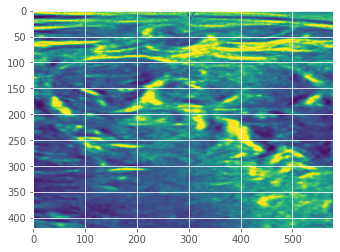

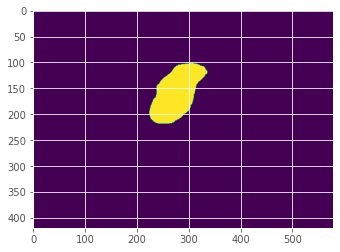

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


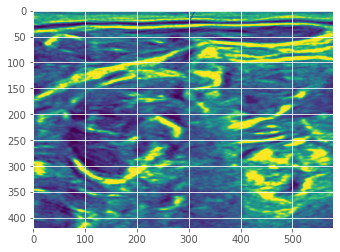

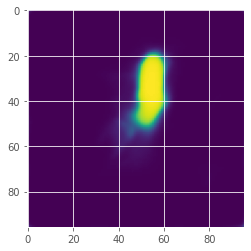

[[47 24 12 ...  4 10 29]
 [19  5  1 ...  0  1  7]
 [10  1  0 ...  0  0  2]
 ...
 [ 9  1  0 ...  0  2 11]
 [16  3  0 ...  2  6 22]
 [38 13  6 ... 12 21 47]]


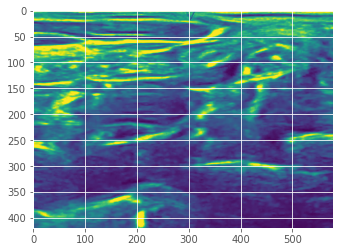

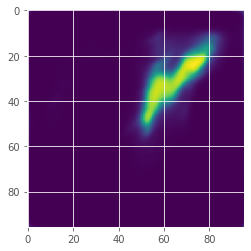

[[45 22 11 ... 29 41 68]
 [18  4  1 ...  7 15 35]
 [ 9  1  0 ...  2  7 22]
 ...
 [ 8  1  0 ...  0  0  3]
 [16  3  1 ...  0  1  9]
 [39 14  7 ...  2  7 28]]


In [58]:
im = imageio.imread('./results/1_ans.tif')
nda = np.array(im)
dimen = nda.shape
print(dimen)
# dimen is 420 x 580 
# TRAINING DATA-------------------------------------------------------------------
img = plt.imread('./train/10_1.tif')
plt.imshow(img)
plt.show()

img = plt.imread('./train/10_1_mask.tif')
plt.imshow(img)
plt.show()
# TESTED DATA-----------------------------------------------------------------------------
img = plt.imread('./test/1001.tif')
plt.imshow(img)
plt.show()

img = plt.imread('./results/1001_ans.tif')
plt.imshow(img)
plt.show()
# -----------------------------------------------------------------------------------------------
img = plt.imread('./test/1010.tif')
plt.imshow(img)
plt.show()

img = plt.imread('./results/1010_ans.tif')
plt.imshow(img)
plt.show()